# A1: Data Curation Assignment
Chang Xu

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2021. It mainly includes three major steps: Data acquisition, Data processing and Analysis.

### Import libraries

In [560]:
import requests
import csv
import pandas as pd
import numpy as np
import json
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Data acquisition

Collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.

In [561]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Create parameters to call the API

In [562]:
# parameters for getting aggregated legacy view data 
params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016073100"
                    }
# December 2007 through July 2016

# parameters for getting aggregated current standard pageview data
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2021093000'
                        }
# July 2015 through last month

# Indicate the header for API calls
headers = {
    'User-Agent': 'https://github.com/maruchang',
    'From': 'xuchang@uw.edu'
}

Use API calls to get mobile, desktop and both Wikipedia traffic data.</br> 
Save output as json files with the given format.

In [563]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

Access desktop and mobile traffic data for Legacy Pagecounts API and get the data using API call function and write to json file 

In [564]:
legacy_access = ['desktop-site', 'mobile-site']
legacy_output = './pagecounts_{}_200712-201607.json'

for access_type in legacy_access:
    params = params_legacy
    params['access-site'] = access_type
    response = api_call(endpoint_legacy, params)
    
    with open(legacy_output.format(access_type), 'w') as out:
        json.dump(response, out)

Access desktop, mobile web, and mobile app traffic data for Pageview API. Get the data using API call function and write to json file

In [565]:
pageviews_access = ['desktop', 'mobile-app', 'mobile-web']
pageviews_output = './pageviews_{}_201507-202109.json'

for access_type in pageviews_access:
    params = params_pageviews
    params['access'] = access_type
    response = api_call(endpoint_pageviews, params)
    
    with open(pageviews_output.format(access_type), 'w') as out:
        json.dump(response, out)

## Step 2: Data processing

Perform a series of processing steps on these data files in order to prepare them for analysis. At the end of this step, we will have a single CSV-formatted data file that can be used in analysis (Step 3) with no significant additional processing.

Convert all saved json files to dataframes and get the raw data from 'items' column. For legacy pagecount data:

In [566]:
# Read json file into data frmae
df_pagecounts_desktop = pd.read_json('pagecounts_desktop-site_200712-201607.json')
df_pagecounts_mobile = pd.read_json('pagecounts_mobile-site_200712-201607.json')

In [567]:
# get only "items" and nomalize the data
df_pagecounts_desktop = pd.json_normalize(df_pagecounts_desktop["items"])
df_pagecounts_mobile = pd.json_normalize(df_pagecounts_mobile["items"])

Similarly, for pageview data

In [568]:
# Pageviews data
df_pageviews_desktop = pd.read_json('pageviews_desktop_201507-202109.json')
df_pageviews_mobile_app = pd.read_json('pageviews_mobile-app_201507-202109.json')
df_pageviews_mobile_web = pd.read_json('pageviews_mobile-web_201507-202109.json')

In [569]:
# get only "items" and nomalize the data
df_pageviews_desktop = pd.json_normalize(df_pageviews_desktop["items"])
df_pageviews_mobile_app = pd.json_normalize(df_pageviews_mobile_app["items"])
df_pageviews_mobile_web = pd.json_normalize(df_pageviews_mobile_web["items"])

Drop unwanted columns and rename the columns

In [570]:
# Pagecounts data
# rename only useful columns
df_pagecounts_desktop = df_pagecounts_desktop[["timestamp", "count"]]
df_pagecounts_mobile = df_pagecounts_mobile[["timestamp", "count"]]

In [571]:
# rename columns
df_pagecounts_desktop = df_pagecounts_desktop.rename(columns = {'count': 'pagecount_desktop_views'})
df_pagecounts_mobile = df_pagecounts_mobile.rename(columns = {'count': 'pagecount_mobile_views'})

For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month. First, get the data seperately.

In [572]:
# Pageviews data
# remain only the useful columns
df_pageviews_desktop = df_pageviews_desktop[["timestamp", "views"]]
df_pageviews_mobile_app = df_pageviews_mobile_app[["timestamp", "views"]]
df_pageviews_mobile_web = df_pageviews_mobile_web[["timestamp", "views"]]

In [573]:
# rename the columns
df_pageviews_desktop = df_pageviews_desktop.rename(columns = {'views': 'pageview_desktop_views'})
df_pageviews_mobile_app = df_pageviews_mobile_app.rename(columns = {'views': 'pageview_mobile_app_views'})
df_pageviews_mobile_web = df_pageviews_mobile_web.rename(columns = {'views': 'pageview_mobile_web_views'})

Merge mobile and desktop dataframes based on timestamp

In [574]:
df_combined = df_pagecounts_desktop.merge(df_pagecounts_mobile, how='outer', on='timestamp').merge(df_pageviews_desktop, how='outer', on='timestamp').merge(df_pageviews_mobile_app, how='outer', on='timestamp').merge(df_pageviews_mobile_web, how='outer', on='timestamp')

For months with 0 pageviews for a given access method (e.g. desktop-site, mobile-app), that value for that (column, month) should be listed as 0

In [575]:
res = df_combined.fillna(0)

Add up desktop view and mobile view for all view data.

In [576]:
# legacy pageview views
res['pageview_mobile_views'] = res['pageview_mobile_app_views'] + res['pageview_mobile_web_views']
res['pageview_all_views'] = res['pageview_desktop_views'] + res['pageview_mobile_views']

Similarly, get all views for pagecount views.

In [577]:
# pagecount views
res['pagecount_all_views'] = res['pagecount_desktop_views'] + res['pagecount_mobile_views']

For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).

In [578]:
res['year'] = res['timestamp'].str[:4]
res['month'] = res['timestamp'].str[4:6]

Reorder the columns

In [579]:
res = res[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

Writing results to a csv file

In [580]:
res.to_csv('en-wikipedia_traffic_200712-202108.csv', index = False)

## Step 3: Analysis

Read data from the csv we just generated from last step

In [581]:
data = pd.read_csv('./en-wikipedia_traffic_200712-202108.csv')

Get the "date" field for drawing, which is the combination of month and year

In [582]:
import datetime

date = []
for i in range(len(data['year'])):
    res = pd.to_datetime(datetime.date(year=int(data['year'][i]), month=int(data['month'][i]), day=1))
    date.append(res)

data['date'] = date
data = data.set_index('date')

Calaulate the data we want to plot: mobile, desktop and mobile + desktop traffic

In [583]:
data['mobile_traffic'] = data['pageview_mobile_views'] + data['pagecount_mobile_views']
data['desktop_traffic'] = data['pageview_desktop_views'] + data['pagecount_desktop_views']
data['all_traffic'] = data['pageview_all_views'] + data['pagecount_all_views']

Change value 0s to NaNs to avoid noise

In [584]:
data = data.replace(to_replace = 0, value = np.nan)

Plot the visualization

<function matplotlib.pyplot.show(close=None, block=None)>

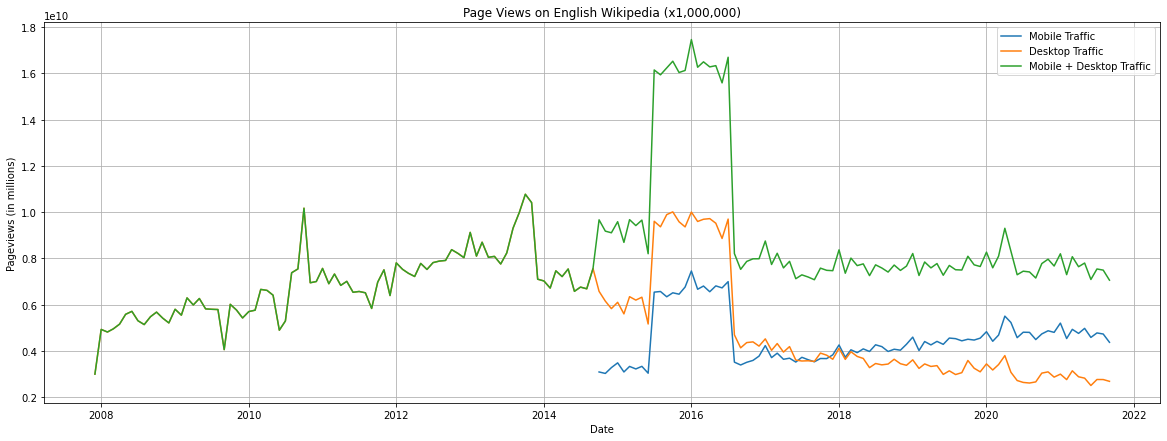

In [585]:
plt.figure(figsize=(20,7))
plt.grid()

plt.plot(data['mobile_traffic'], label = "Mobile Traffic")
plt.plot(data['desktop_traffic'], label = "Desktop Traffic")
plt.plot(data['all_traffic'], label = "Mobile + Desktop Traffic")

plt.legend()
plt.xlabel('Date')
plt.ylabel('Pageviews (in millions)')
plt.title('Page Views on English Wikipedia (x1,000,000)')

plt.savefig('./wikipedia_traffic_200712-202109.png')
plt.show